In [2]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import collab2.foraging.toolkit as ft
from collab2.foraging.toolkit import (
    dataObject,
    plot_predictor,
    rescale_to_grid,
    subset_frames_evenly_spaced,
)
from collab2.utils import find_repo_root

from collab2.foraging.toolkit.waic import compute_waic

logging.basicConfig(format="%(message)s", level=logging.INFO)

root = find_repo_root()

# users can ignore smoke_test -- it's for automatic testing on GitHub,
# to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
smoke_test = True
frames = 150 if smoke_test else 300
frames_sps = 150 if smoke_test else 2300
sampling_rate = 0.001 if smoke_test else 0.01

notebook_starts = time.time()

In [22]:
ducks_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)
sparrows_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)

ducks_raw = ducks_raw.rename(columns={"bird": "forager"})
sparrows_raw = sparrows_raw.rename(columns={"bird": "forager"})

ducks_sub = ft.subset_frames_evenly_spaced(ducks_raw, frames)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)
ducks_object = dataObject(foragersDF = ducks_sub)

sps_sub = ft.subset_frames_evenly_spaced(sparrows_raw, frames_sps)
sps_sub = ft.rescale_to_grid(sps_sub, 90)
sps_object = dataObject(foragersDF = sps_sub)   


original_frames: 1451
original_shape: (8867, 4)
resulting_frames: 150
resulting_shape: (933, 4)
original_frames: 11550
original_shape: (22821, 4)
resulting_frames: 141
resulting_shape: (323, 4)


/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning:


                    Missing frames encountered for forager 0, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    

/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning:


                    Missing frames encountered for forager 1, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    

/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py

In [23]:
datalist = ducks_object.foragers
source = ducks_sub

# we do this as central park birds data contains many birds flying away

def test_data_object_correctness(datalist, source):
    for forager in source['forager'].unique():
        for time in source['time'].unique():

            data = datalist[forager][datalist[forager]["time"] == time]
            sourced = source[(source["forager"] == forager) & (source["time"] == time)]
            
            if len(sourced) > 0:
                assert len(sourced) == 1
                assert sourced["x"].values == data["x"].values
                assert sourced["y"].values == data["y"].values

            if len(sourced) == 0:
                assert data["x"].isna().sum() == len(data)
                
    print("Data tests passed")

test_data_object_correctness(ducks_object.foragers, ducks_sub)
test_data_object_correctness(sps_object.foragers, sps_sub)


Data tests passed
Data tests passed


In [24]:
# let's get a feel for the distance distributions
# might take a while to run
duck_distances = ft.foragers_to_forager_distances(ducks_object)
sps_distances = ft.foragers_to_forager_distances(sps_object)


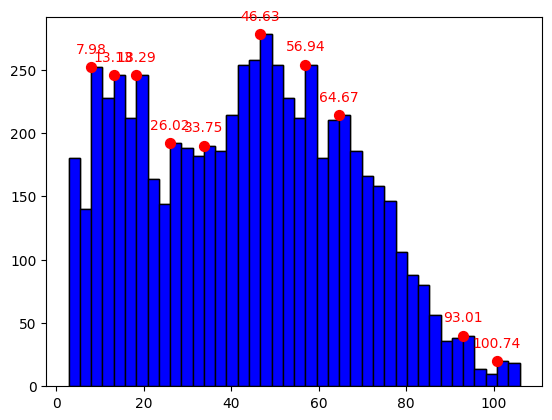

In [26]:
ft.distances_and_peaks(duck_distances)


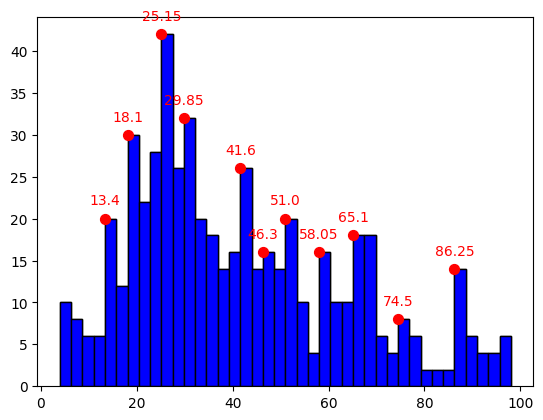

In [27]:
ft.distances_and_peaks(sps_distances)

In [28]:
# for instance, it seems that as a proximity parameter setting
# values around 25 should work well for sparrows, less so ducks
# values around 55 should work well for ducks, not terribly for sparrows
# values around 80 should not work very well for either
# we'll keep these in mind as sanity checks

local_windows_kwargs = {
    "window_size": 20,  # in paper: locust sight goes beyond the grid
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}


predictor_kwargs = {
    "access": {
        "decay_factor": 0.2,
    },
}

# Emily wanted to try out all these values
# Rafal thinks these are too many options and prefers staying with 20, 50, and 80
# reason: histograms get cluttered and clarity is lost
proximity_optimal_candidates = [25, 55, 80] #[10, 20, 30, 40, 50, 60, 70, 80] 

for opt in proximity_optimal_candidates:
    predictor_kwargs[f"proximity_{opt}"] =  {
        "interaction_length": 90 / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": opt/2,
        "optimal_distance": opt,
        "proximity_decay": .5,
    }


score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

ducks_derivedDF = ft.derive_predictors_and_scores(
    ducks_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

sps_derivedDF = ft.derive_predictors_and_scores(
    sps_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)
display(ducks_derivedDF.head())

2024-10-08 10:36:02,288 - access completed in 1.32 seconds.
2024-10-08 10:36:06,967 - proximity_25 completed in 4.68 seconds.
2024-10-08 10:36:12,151 - proximity_55 completed in 5.18 seconds.
2024-10-08 10:36:16,751 - proximity_80 completed in 4.60 seconds.
2024-10-08 10:36:17,721 - nextStep_linear completed in 0.97 seconds.
2024-10-08 10:36:18,696 - nextStep_sublinear completed in 0.97 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 20922/944778 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      

2024-10-08 10:36:22,206 - access completed in 0.48 seconds.
2024-10-08 10:36:23,145 - proximity_25 completed in 0.94 seconds.
20

x   y  distance_to_forager  time  forager    access  proximity_25  \
0  52  18            20.000000    56        0  0.018316     -0.028529   
1  53  12            19.924859    56        0  0.018593      0.621124   
2  53  13            19.646883    56        0  0.019656      0.522300   
3  53  14            19.416488    56        0  0.020583      0.418141   
4  53  15            19.235384    56        0  0.021342      0.310435   

   proximity_55  proximity_80  distance_to_next_step  nextStep_linear  \
0     -0.851624     -0.931692              20.000000         0.000000   
1     -0.597825     -0.810107              19.924859         0.003757   
2     -0.645356     -0.833328              19.646883         0.017656   
3     -0.690601     -0.855224              19.416488         0.029176   
4     -0.733412     -0.875761              19.235384         0.038231   

   nextStep_sublinear  access_scaled  proximity_25_scaled  \
0            0.000000       0.000000             0.485736   
1            0.001880       0.000283             0.810562   
2            0.008867       0.001365             0.761150   
3            0.014696       0.002310             0.709070   
4            0.019302       0.003083             0.655218   

   proximity_55_scaled  proximity_80_scaled  nextStep_linear_scaled  \
0             0.074188             0.049491                0.000000   
1             0.201087             0.137584                0.003757   
2             0.177322             0.120760                0.017656   
3             0.154699             0.104895                0.029176   
4             0.133294             0.090015                0.038231   

   nextStep_sublinear_scaled  
0                   0.000000  
1                   0.001880  
2                   0.008867  
3                   0.014696  
4                   0.019302

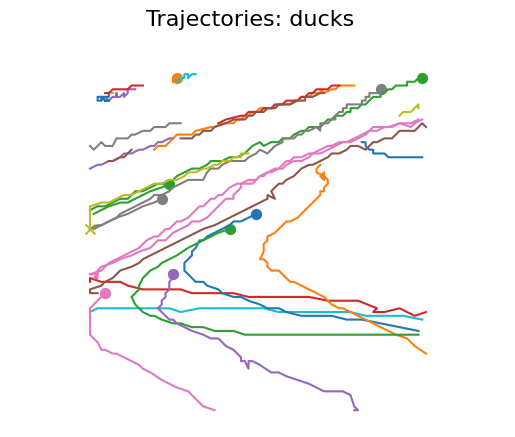

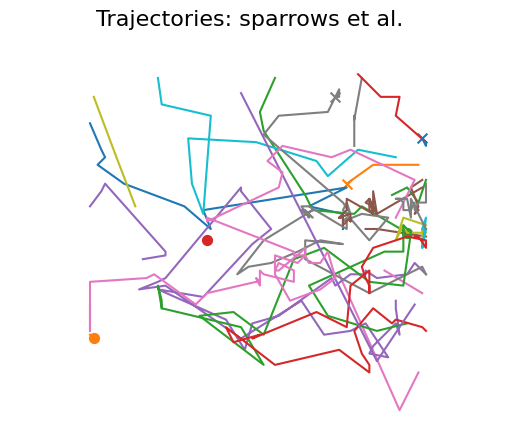

In [29]:
fig = ft.plot_trajectories(ducks_object.foragersDF, "ducks", legend = False) 
# too many birds to show legend
fig.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_ducks.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

plt = ft.plot_trajectories(sps_object.foragersDF, "sparrows et al.", legend = False)
plt.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_sps.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

In [30]:
fig = ft.plot_distances(sps_distances, "sparrows et al.")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_sps.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

fig = ft.plot_distances(duck_distances, "ducks")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_ducks.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

notebook_ends = time.time()

print(
    f"notebook took {notebook_ends - notebook_starts} seconds, {(notebook_ends - notebook_starts)/60} minutes to run"
)

notebook took 1364.7005550861359 seconds, 22.745009251435597 minutes to run


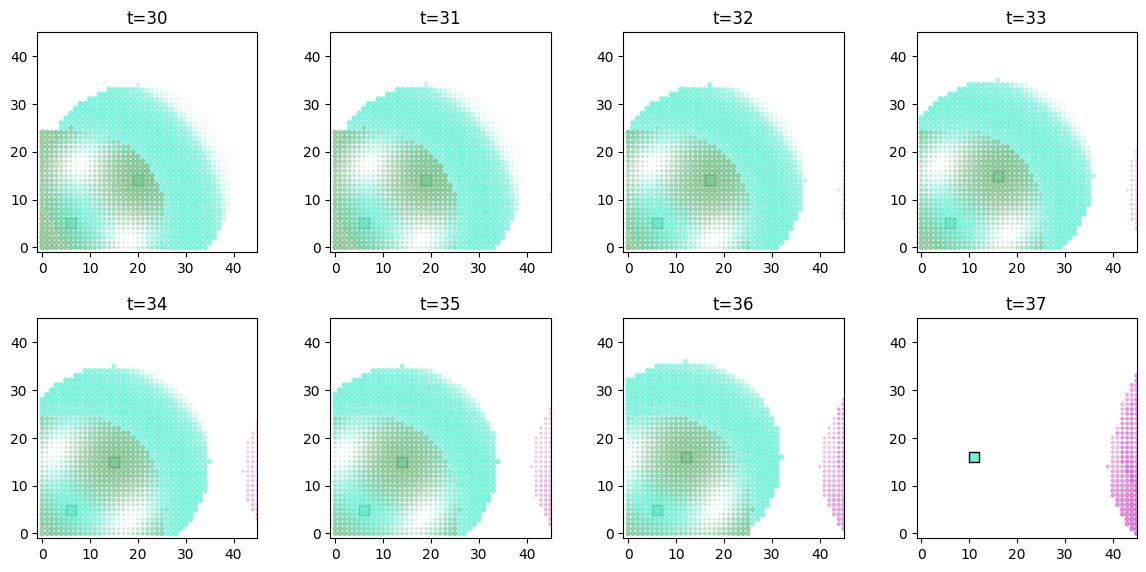

In [32]:
plot_predictor(
    ducks_object.foragers,
    ducks_object.derived_quantities["proximity_25"],
    predictor_name="proximity_25",
    time=range(30,38),
    grid_size=45,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=list(range(20)),
    forager_predictor_indices=list(range(20)),
)

2024-10-08 10:47:55,024 - Starting SVI inference with 15 iterations.


Sample size: 46193
[iteration 0001] loss: 122654.7656


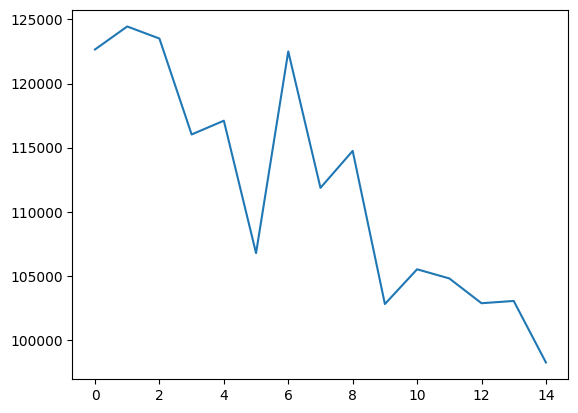

2024-10-08 10:47:55,353 - SVI inference completed in 0.33 seconds.


dict_keys(['bias_continuous_nextStep_sublinear', 'weight_continuous_proximity_25_scaled_nextStep_sublinear', 'weight_continuous_access_scaled_nextStep_sublinear', 'bias_continuous_nextStep_sublinear_sigma', 'weight_continuous_proximity_25_scaled_nextStep_sublinear_sigma', 'weight_continuous_access_scaled_nextStep_sublinear_sigma', 'proximity_25_scaled', 'access_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_25_scaled_nextStep_sublinear', 'weight_continuous_access_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_25_scaled_nextStep_sublinear
       mean       std        5%       25%       50%      75%       95%
0  0.130326  0.087903 -0.002815  0.093136  0.136831  0.19217  0.232616 

Site: weight_continuous_access_scaled_nextStep_sublinear
       mean       std        5%       25%      50%       75%       95%
0  0.521192  0.093924  0.369794  0.481035  0.54512  0.582348  0.624028 



NameError: name 'compute_waic' is not defined

In [38]:
waic_scores = {}
results = {}

data_objects = {"ducks": ducks_object, "sparrows": sps_object}

for key in data_objects:
    results[key] = {}
    waic_scores[key] = {}

    for proximity_candidate in proximity_optimal_candidates[:1]:

        predictors = [f"proximity_{proximity_candidate}_scaled", "access_scaled"]
        outcome_vars = ["nextStep_sublinear"]

        predictor_dict, outcome_dict = ft.prep_data_for_inference(
            object,
            predictors,
            outcome_vars,
            subsample_rate=0.05,
        )

        model = ft.HeteroskedasticLinear(
            predictor_dict, outcome_dict
            )

        outcome = ft.get_samples(
        model=model,
        predictors=predictor_dict,
        outcome=outcome_dict,
        num_svi_iters=15, #00,
        num_samples=10,#00,
        )

        results[key][proximity_candidate] = outcome
        waic_scores[key][proximity_candidate] = compute_waic(
        model=model,
        guide=outcome['guide'],
        num_particles=10,#00,
        sites=["housing_units"],
        max_plate_nesting=9,
        predictors = predictor_dict,
        outcome = outcome_dict,
        )['waic']



